In [1]:
import pandas as pd
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [36]:
results_df = pd.read_csv('results_df.csv')
results_df.loc[results_df['model_name'] == 'extremelyfastdecisiontreeclassifier', 'model_name'] = 'EFDT'
results_df.loc[results_df['model_name'] == 'hoeffdingtreeclassifier', 'model_name'] = 'HT'

In [112]:
results_df

,model_name,drift_name,feature_selector_name,learning_threshold,iteration,accuracy,drifts_detected,model_args,ticker
0,HT,adwin,selectkbest,100,1,0.516,0,"grace_period=100, max_depth=4, delta=0.001",AAPL
1,HT,adwin,selectkbest,100,2,0.516,0,"grace_period=100, max_depth=4, delta=0.001",AAPL
2,HT,adwin,selectkbest,100,3,0.516,0,"grace_period=100, max_depth=4, delta=0.001",AAPL
3,HT,adwin,selectkbest,100,4,0.516,0,"grace_period=100, max_depth=4, delta=0.001",AAPL
4,HT,adwin,selectkbest,100,5,0.516,0,"grace_period=100, max_depth=4, delta=0.001",AAPL
...,...,...,...,...,...,...,...,...,...
15745,randomforest,bollingerband,selectkbest_sklearn,2000,1,0.507,7,"n_estimators=300, max_depth=20, max_features=log2",AAPL
15746,randomforest,bollingerband,selectkbest_sklearn,2000,2,0.510,7,"n_estimators=300, max_depth=20, max_features=log2",AAPL
15747,randomforest,bollingerband,selectkbest_sklearn,2000,3,0.512,7,"n_estimators=300, max_depth=20, max_features=log2",AAPL
15748,randomforest,bollingerband,selectkbest_sklearn,2000,4,0.510,7,"n_estimators=300, max_depth=20, max_features=log2",AAPL


In [49]:
sqldf('''

select model_name
from results_df
group by model_name

''')

,model_name
0,EFDT
1,HT
2,mlp
3,randomforest
4,xgboost


### MODELS OVERVIEW

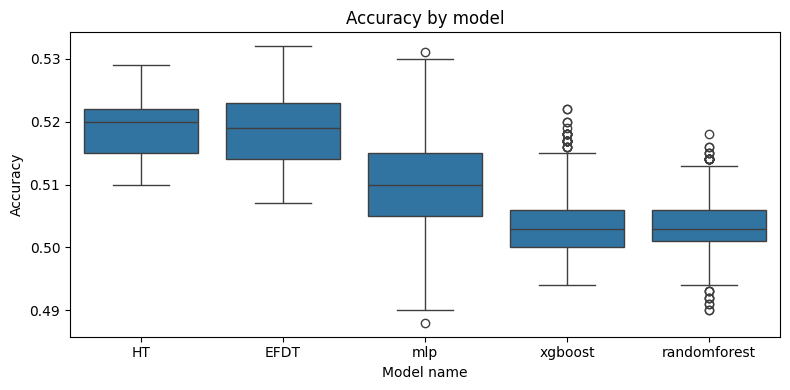

In [114]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='model_name', y="accuracy", data=results_df)
plt.title("Accuracy by model")
# plt.xticks(rotation=45)
plt.xlabel("Model name")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig('result_df_images_to_report/models_comparison_accuracy.png')
plt.show()


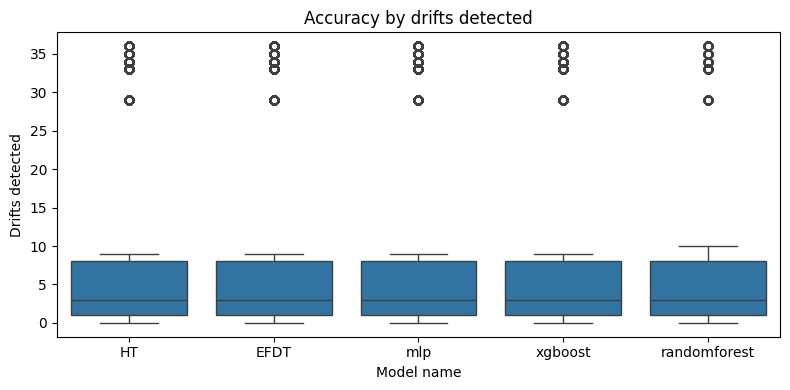

In [115]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='model_name', y="drifts_detected", data=results_df)
plt.title("Accuracy by drifts detected")
# plt.xticks(rotation=45)
plt.xlabel("Model name")
plt.ylabel("Drifts detected")
plt.tight_layout()
plt.savefig('result_df_images_to_report/models_comparison_drifts_detected.png')
plt.show()


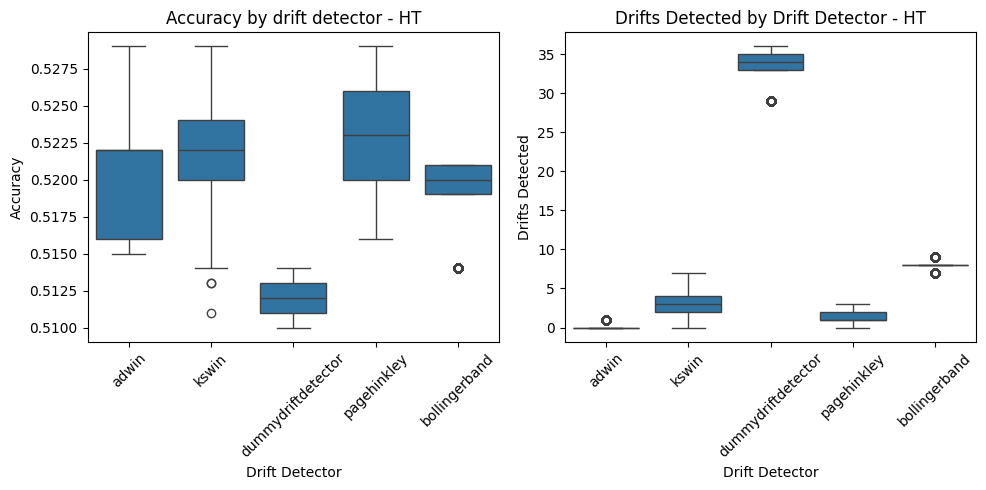

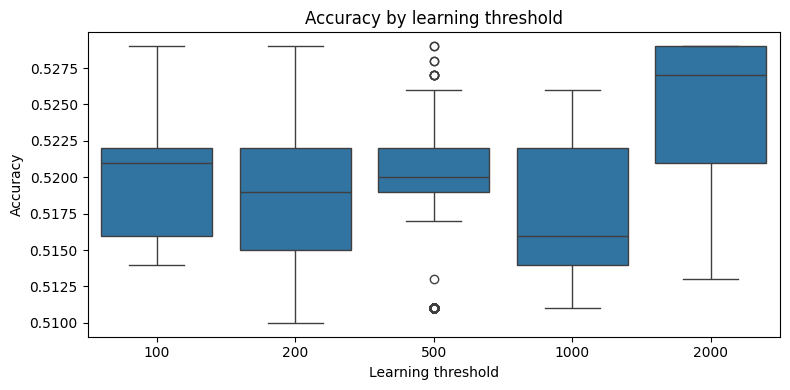

,grace_period,max_depth,delta,avg(drifts_detected),avg(accuracy),max(accuracy)
0,300,12,1e-05,9.272,0.519576,0.529
1,300,12,1e-07,9.136,0.519544,0.529
2,100,12,0.001,9.144,0.519472,0.529
3,100,12,1e-05,9.248,0.519448,0.529
4,300,8,1e-07,9.216,0.519424,0.529
22,200,4,1e-05,9.240,0.519240,0.529
23,200,12,1e-07,9.120,0.519240,0.529
24,300,4,1e-07,9.248,0.519232,0.529
25,300,12,0.001,9.256,0.519216,0.529
26,200,8,1e-07,9.264,0.519208,0.529


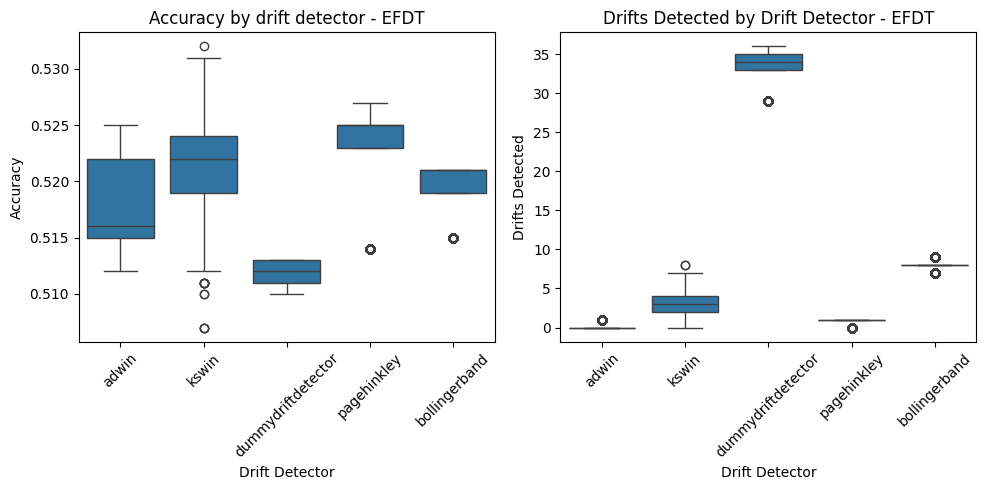

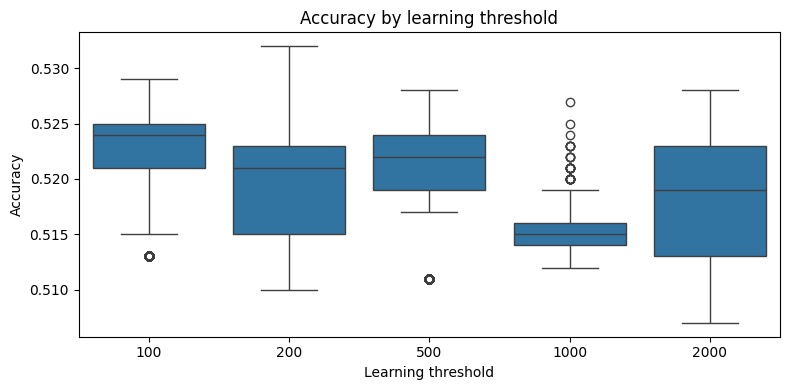

,grace_period,max_depth,delta,avg(drifts_detected),avg(accuracy),max(accuracy)
0,300,8,1e-05,9.120,0.518920,0.531
1,300,12,1e-07,9.040,0.518912,0.529
2,100,8,1e-07,9.040,0.518840,0.528
3,200,12,1e-07,9.104,0.518792,0.527
4,200,8,1e-07,9.120,0.518784,0.527
22,100,12,1e-07,8.984,0.518544,0.527
23,200,12,1e-05,9.232,0.518496,0.527
24,100,4,0.001,9.072,0.518456,0.528
25,100,8,1e-05,9.072,0.518440,0.527
26,300,12,0.001,8.976,0.518344,0.527


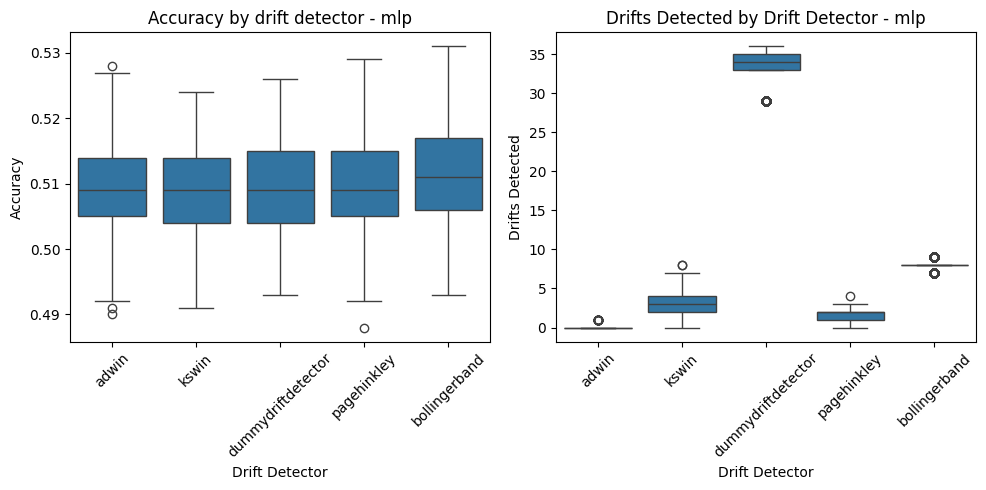

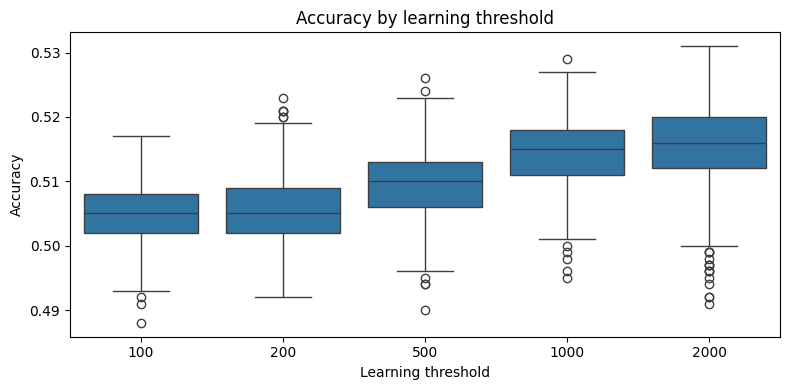

,hidden_layer_sizes,learning_rate_init,alpha,avg(drifts_detected),avg(accuracy),max(accuracy)
0,(50,0.1,0.001,9.280,0.511544,0.528
1,(100,0.01,0.0001,9.248,0.510856,0.527
2,(150,0.1,0.0001,9.264,0.510792,0.528
3,(50,0.001,0.0001,9.240,0.510696,0.527
4,(100,0.001,0.0001,9.192,0.510696,0.530
22,(100,0.001,1e-05,9.232,0.509496,0.527
23,(150,0.01,0.0001,9.192,0.509472,0.524
24,(100,0.1,0.001,9.232,0.509464,0.525
25,(100,0.01,0.001,9.144,0.509048,0.524
26,(100,0.01,1e-05,9.264,0.508856,0.526


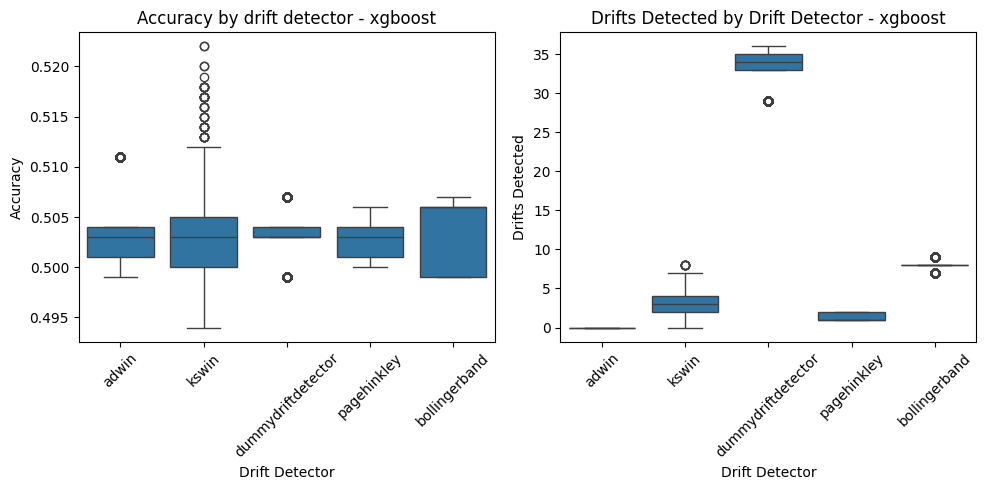

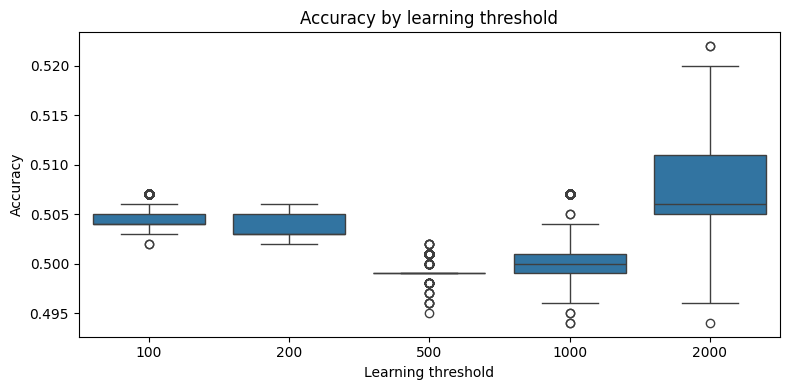

,n_estimators,max_depth,learning_rate,avg(drifts_detected),avg(accuracy),max(accuracy)
0,200,9,0.2,9.136,0.503496,0.518
1,100,9,0.1,9.104,0.503440,0.520
2,100,3,0.1,9.256,0.503408,0.520
3,300,6,0.01,9.216,0.503384,0.517
4,300,9,0.1,9.272,0.503360,0.518
22,200,3,0.1,9.296,0.503128,0.522
23,300,3,0.1,9.216,0.503112,0.512
24,100,9,0.01,9.192,0.503096,0.512
25,300,3,0.2,9.192,0.503072,0.511
26,200,9,0.01,9.168,0.503056,0.514


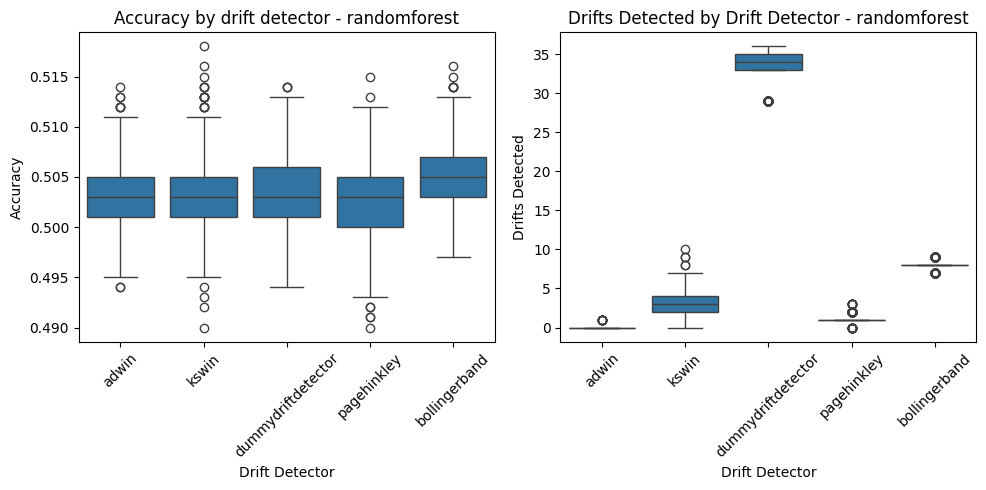

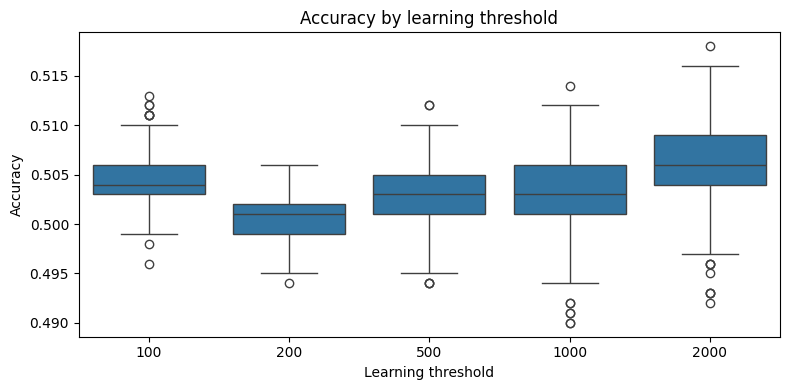

,n_estimators,max_depth,max_features,avg(drifts_detected),avg(accuracy),max(accuracy)
0,100,20,sqrt,9.120,0.504184,0.516
1,200,None,sqrt,9.208,0.503896,0.511
2,300,10,sqrt,9.232,0.503856,0.514
3,300,None,log2,9.096,0.503840,0.514
4,300,None,sqrt,9.048,0.503808,0.515
13,200,20,log2,9.144,0.503416,0.513
14,200,10,log2,9.144,0.503328,0.513
15,100,20,log2,9.192,0.503112,0.518
16,100,10,log2,9.048,0.503104,0.512
17,100,None,log2,9.216,0.503016,0.512


In [116]:
def model_overview(model_name, args_limit=10, to_latex=False):
    
    # drift_comparison = sqldf('''

    #     select model_name, drift_name, avg(drifts_detected), avg(accuracy), max(accuracy)

    #     from results_df
    #     where model_name = '{model_name}'

    #     group by model_name, drift_name
    #     order by avg(accuracy) desc
    # '''.format(model_name=model_name))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    model_results = results_df.loc[results_df['model_name'] == model_name]

    sns.boxplot(x='drift_name', y="accuracy", data=model_results, ax=axes[0])
    axes[0].set_title("Accuracy by drift detector - {model_name}".format(model_name=model_name))
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_xlabel("Drift Detector")
    axes[0].set_ylabel("Accuracy")

    sns.boxplot(x='drift_name', y="drifts_detected", data=model_results, ax=axes[1])
    axes[1].set_title("Drifts Detected by Drift Detector - {model_name}".format(model_name=model_name))
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_xlabel("Drift Detector")
    axes[1].set_ylabel("Drifts Detected")

    plt.tight_layout()
    if to_latex:
        plt.savefig('result_df_images_to_report/drift_comparison_{model_name}.png'.format(model_name=model_name))
    else:
        plt.show()

    plt.figure(figsize=(8, 4))

    sns.boxplot(x='learning_threshold', y="accuracy", data=model_results)
    plt.title("Accuracy by learning threshold")
    # plt.xticks(rotation=45)
    plt.xlabel("Learning threshold")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    if to_latex:
        plt.savefig('result_df_images_to_report/learning_threshold_comparison_{model_name}.png'.format(model_name=model_name))
    else:
        plt.show()

    model_args_comparison = sqldf('''

        select model_args, avg(drifts_detected), avg(accuracy), max(accuracy)

        from results_df
        where model_name = '{model_name}'

        group by model_args
        order by avg(accuracy) desc
    '''.format(model_name=model_name)
    )

    split_args = model_args_comparison['model_args'].str.split(',s*')
    param_dicts = split_args.apply(
    lambda pairs: dict(pair.split('=') for pair in pairs if '=' in pair)
        )
    args_df = pd.json_normalize(param_dicts)
    model_args_comparison = pd.concat([args_df, 
                                       model_args_comparison.loc[:,['avg(drifts_detected)', 'avg(accuracy)', 'max(accuracy)']]], axis=1)

    model_args_comparison = pd.concat([model_args_comparison.iloc[:args_limit//2,:],
                                       model_args_comparison.iloc[-args_limit//2:,:]])

    if to_latex:
        # print("\n% Drift Comparison Table - {model_name}".format(model_name=model_name))
        # print(drift_comparison.to_latex(index=False, float_format="%.3f").replace('_', r'\_'))
        print("\n% Model Args Comparison Table - {model_name}".format(model_name=model_name))

        latex_model_args = "\\begin{table}[ht]\n" + \
                            model_args_comparison.to_latex(index=False, float_format="%.3f").replace('_', r'\_') + \
                            f"\\caption{{Model Args Comparison Table - {model_name} ({args_limit//2} best and worst)}}\n\\end{{table}}"
        print(latex_model_args)

    else:
        # display(drift_comparison)
        display(model_args_comparison)

for model_name in results_df['model_name'].unique().tolist():
    model_overview(model_name, 10, False)

In [ ]:
10 // 2

5

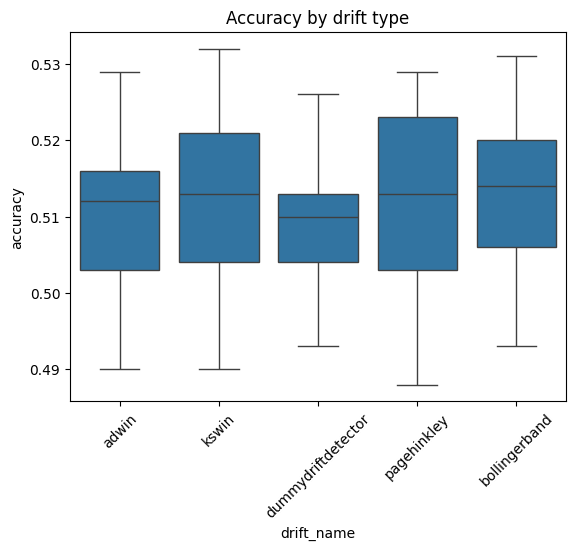

In [44]:
sns.boxplot(x='drift_name', y="accuracy", data=results_df)
plt.title("Accuracy by drift type")
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

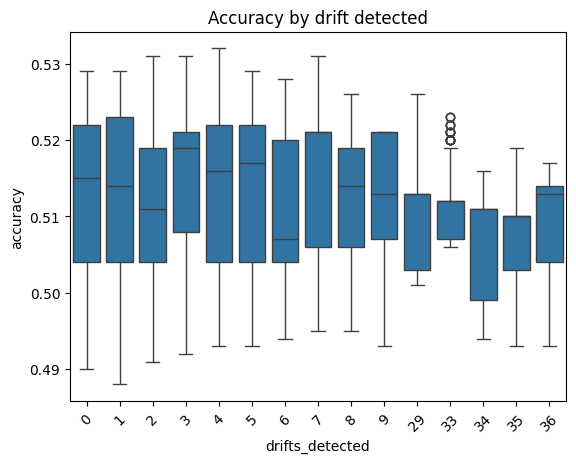

In [25]:
sns.boxplot(x='drifts_detected', y="accuracy", data=results_df)
plt.title("Accuracy by drift detected")
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()